In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' to suppress all messages
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
label_encoder = LabelEncoder()
pd.options.mode.chained_assignment = None


In [193]:
raw_data_path = './data/data_by_table/pre_24h_data_v3.csv'
flag_data_path = './data/data_by_table/ground_truth.csv'

data_df = pd.read_csv(raw_data_path)
flag_data_df = pd.read_csv(flag_data_path)
data_df['BMI'] = data_df['weight_kg'] / ((data_df['height_cm'] / 100) ** 2)
data_df['gender'] = label_encoder.fit_transform(data_df['gender'])
data_df['race'] = label_encoder.fit_transform(data_df['race'])
data_df['first_careunit'] = label_encoder.fit_transform(data_df['first_careunit'])
data_df['admission_type'] = label_encoder.fit_transform(data_df['admission_type'])
data_df['insurance'] = label_encoder.fit_transform(data_df['insurance'])
data_df = data_df.drop(columns=['height_cm', 'weight_kg'])
print(data_df.columns)

Index(['Unnamed: 0', 'charttime', 'stay_id', 'O2_flow_x', 'heart_rate', 'sbp',
       'dbp', 'mbp', 'resp_rate', 'spo2', 'O2_flow_y', 'peep', 'fio2',
       'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure',
       'GCS', 'age_now', 'gender', 'insurance', 'race', 'admission_type',
       'first_careunit', 'tobacco', 'label', 'Rev_h', 'dod_h', 'BMI'],
      dtype='object')


In [194]:
def check_missing_values(df):
    
    if df.isna().any().any():
        return 1 
    else:
        return 0 

In [182]:
def get_label(id_df):
    if not check_missing_values(id_df):
            label = id_df['label'].iloc[0]
            if label == 1:
                label = -72
            else:
                if id_df['Rev_h'].iloc[0] != -1000:
                    label = 48 - id_df['Rev_h'].iloc[0]
                elif id_df['dod_h'].iloc[0] != -1000 and id_df['dod_h'].iloc[0]>0 and id_df['dod_h'].iloc[0]<48:
                    label = 96 - id_df['dod_h'].iloc[0]*2
                else:
                    label = 96
    return label

In [206]:
def lstm_data(flag_data_df, data_df):
    total_x = []
    total_y = []
    for index, row in flag_data_df.iterrows():
        id_df = data_df[data_df['stay_id'] == row['stay_id']]
        if not check_missing_values(id_df):
            label = get_label(id_df)
            id_df = id_df.drop(columns='stay_id')
            id_df = id_df.drop(columns='label')
            id_df = id_df.drop(columns='charttime')
            id_df = id_df.drop(columns='Rev_h')
            id_df = id_df.drop(columns='dod_h')
            total_x.append(id_df.values)
            total_y.append(label)

    total_x = np.array(total_x)
    total_y = np.array(total_y).reshape(-1, 1)
    return total_x, total_y

In [184]:
def get_diff_value(df,colname,start, end):
    start = 23 - start
    end = 23 - end
    df = df.reset_index()
    return (df[colname][end]+df[colname][end-1]+df[colname][end-2]) - (df[colname][start]+df[colname][start+1]+df[colname][start+2])

In [207]:
def NN_data(flag_data_df, data_df, hour = 23):
    total_x = []
    total_y = []
    for index, row in flag_data_df.iterrows():
        id_df = data_df[data_df['stay_id'] == row['stay_id']]
        if not check_missing_values(id_df):
            label = get_label(id_df)
            id_df = id_df.drop(columns='stay_id')
            id_df = id_df.drop(columns='label')
            id_df = id_df.drop(columns='charttime')
            id_df = id_df.drop(columns='Rev_h')
            id_df = id_df.drop(columns='dod_h')


            
            zero_hr_values = id_df.iloc[hour, :].values
            total_x.append(zero_hr_values)
            total_y.append(label)
    total_x = np.array(total_x)
    total_y = np.array(total_y).reshape(-1, 1)
    return total_x, total_y
        

In [187]:
lstm_x, lstm_y = lstm_data(flag_data_df, data_df)

In [208]:
NN_x, NN_y = NN_data(flag_data_df, data_df)
print(NN_x.shape)
print(NN_y.shape)

(2003, 23)
(2003, 1)


In [209]:
print(NN_y[23])

[44.]


In [210]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

def train_module(X_train, y_train, X_test, y_test, epoch, learning_rate, batch):

    # Define model and train
    def build_lstm_model(timesteps, num_features):
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(128, input_shape=(timesteps, num_features)),
            tf.keras.layers.Dense(1) 
        ])
        model.build(input_shape=(None, timesteps, num_features))
        return model

    model = build_lstm_model(timesteps=X_train.shape[1], num_features=X_train.shape[2])

    model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mean_squared_error') 

    model.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_data=(X_test, y_test))
    return model



In [223]:
def train_NN_module(X_train, y_train, X_test, y_test, epoch, learning_rate, batch, verbose=1):

    # Define model and train
    def build_nn_model(input_shape):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='mean_squared_error')
        return model

    # Build and compile the model
    model = build_nn_model(input_shape=(X_train.shape[1],))

    model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mean_squared_error') 

    model.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_data=(X_test, y_test), verbose=verbose)
    return model

In [231]:
total_x, total_y = NN_data(flag_data_df, data_df, 23)
# total_x = lstm_x
# total_y = lstm_y
total_x = total_x.astype(np.float32)
total_y = total_y.astype(np.float32)
total_x[np.isinf(total_x)] = np.nan
total_x[np.abs(total_x) > 1e6] = np.nan
# Handle NaN values by replacing them with zeros (you can choose a different strategy)
total_x[np.isnan(total_x)] = 0.0
scaler = MinMaxScaler()
total_x_normalized = scaler.fit_transform(total_x.reshape(-1, total_x.shape[-1])).reshape(total_x.shape)

X_train, X_test, y_train, y_test = train_test_split(total_x_normalized, total_y, test_size=0.2, random_state=4277)
print(X_train.shape)
print(y_train.shape)
model = train_NN_module(X_train, y_train, X_test, y_test, epoch= 50, learning_rate=0.001, batch=32)

(1602, 23)
(1602, 1)
Epoch 1/50
51/51 [==============================] - 1s 7ms/step - loss: 4751.2241 - val_loss: 4348.2285
Epoch 2/50
51/51 [==============================] - 0s 5ms/step - loss: 4173.5200 - val_loss: 3896.0566
Epoch 3/50
51/51 [==============================] - 0s 4ms/step - loss: 4019.6631 - val_loss: 3769.8418
Epoch 4/50
51/51 [==============================] - 0s 5ms/step - loss: 3795.4590 - val_loss: 3543.2114
Epoch 5/50
51/51 [==============================] - 0s 5ms/step - loss: 3505.5686 - val_loss: 3268.8569
Epoch 6/50
51/51 [==============================] - 0s 4ms/step - loss: 3236.5137 - val_loss: 3185.5574
Epoch 7/50
51/51 [==============================] - 0s 4ms/step - loss: 3171.0396 - val_loss: 3123.6440
Epoch 8/50
51/51 [==============================] - 0s 4ms/step - loss: 3045.7007 - val_loss: 3074.3047
Epoch 9/50
51/51 [==============================] - 0s 4ms/step - loss: 3028.7988 - val_loss: 3148.1987
Epoch 10/50
51/51 [========================

In [232]:
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0, 1, 0)
y_label = np.where(y_test > 0, 1, 0)

13/13 [==============================] - 0s 3ms/step


AUC-ROC: 0.7244525547445255


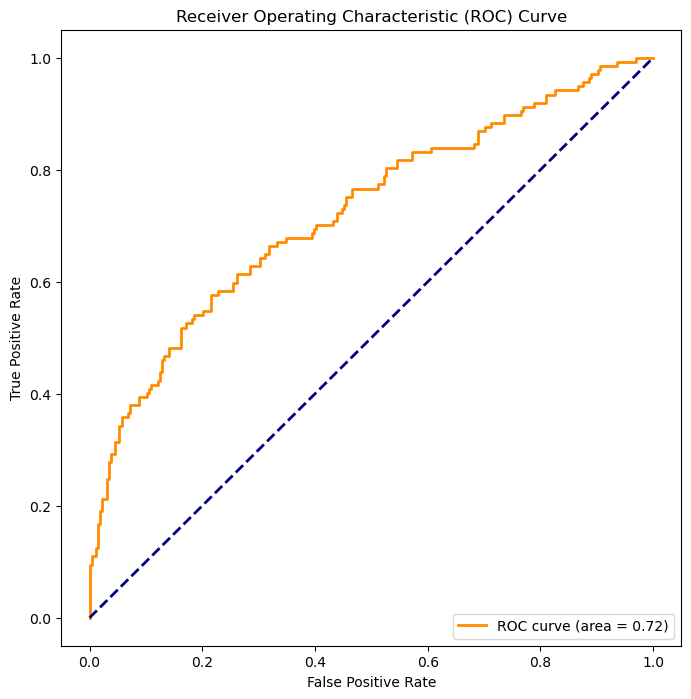

In [233]:
fpr, tpr, _ = roc_curve(y_label, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("AUC-ROC:", roc_auc)
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# experiment

In [234]:
hour_before_weaninig = []
auroc = []
models = []

for i in range (24):
    total_x, total_y = NN_data(flag_data_df, data_df, i)
    total_x = total_x.astype(np.float32)
    total_y = total_y.astype(np.float32)
    total_x[np.isinf(total_x)] = np.nan
    total_x[np.abs(total_x) > 1e6] = np.nan
    total_x[np.isnan(total_x)] = 0.0
    scaler = MinMaxScaler()
    total_x_normalized = scaler.fit_transform(total_x.reshape(-1, total_x.shape[-1])).reshape(total_x.shape)
    X_train, X_test, y_train, y_test = train_test_split(total_x_normalized, total_y, test_size=0.2, random_state=42)
    model = train_NN_module(X_train, y_train, X_test, y_test, epoch= 100, learning_rate=0.001, batch=32, verbose=0)
    y_pred_proba = model.predict(X_test)
    y_pred = np.where(y_pred_proba > 0, 1, 0)
    y_label = np.where(y_test > 0, 1, 0)
    fpr, tpr, _ = roc_curve(y_label, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    hour_before_weaninig.append(i)
    auroc.append(roc_auc)
    models.append(model)
    print(i, roc_auc)

13/13 [==============================] - 0s 2ms/step
0 0.651231527093596
13/13 [==============================] - 0s 2ms/step
1 0.6619321291735085
13/13 [==============================] - 0s 2ms/step
2 0.6769293924466339
13/13 [==============================] - 0s 2ms/step
3 0.6805418719211823
13/13 [==============================] - 0s 2ms/step
4 0.6584838533114395
13/13 [==============================] - 0s 2ms/step
5 0.6759715380405036
13/13 [==============================] - 0s 3ms/step
6 0.6810892172961138
13/13 [==============================] - 0s 2ms/step
7 0.6718117131910235
13/13 [==============================] - 0s 2ms/step
8 0.6512862616310893
13/13 [==============================] - 0s 2ms/step
9 0.6666666666666667
13/13 [==============================] - 0s 2ms/step
10 0.6746305418719211
13/13 [==============================] - 0s 2ms/step
11 0.6755062944718118
13/13 [==============================] - 0s 2ms/step
12 0.6614668856048167
13/13 [=============================

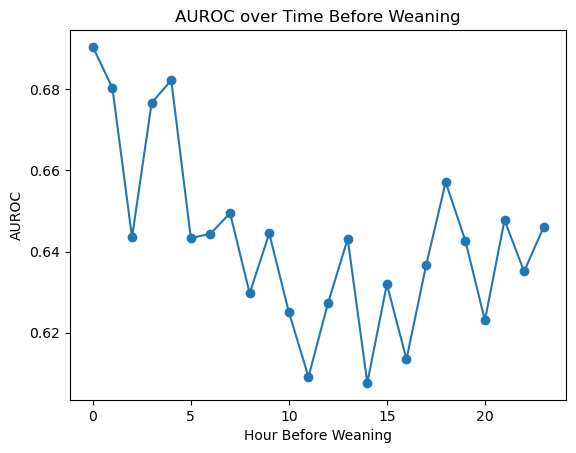

In [138]:
import matplotlib.pyplot as plt
hour_before_weaninig = hour_before_weaninig[::-1]
# 画折线图
plt.plot(hour_before_weaninig, auroc, marker='o')

# 添加标签和标题
plt.xlabel('Hour Before Weaning')
plt.ylabel('AUROC')
plt.title('AUROC over Time Before Weaning')

# 显示图形
plt.show()


In [ ]:
def plot_next_24h(target_id, data_df, models, hour = 8):
    survive_score = []
    id_df = data_df[data_df['stay_id'] == target_id]
    id_df = id_df.reset_index()
    id_df = id_df.drop(columns='label')
    id_df = id_df.drop(columns='charttime')
    input = id_df.iloc[23-8, :].values
    input = input.reshape((1, -1))
    print(input.shape)
    for i in range (24):
        output = models[i].predict(input)
        survive_score.append(output[0])
    return survive_score


In [ ]:
target_id = 30832709
survive_score = plot_next_24h(target_id, data_df, models)
plt.plot(survive_score, auroc, marker='o')

plt.xlabel('after n hour weaning')
plt.ylabel('survive_score')
plt.title('survive_score over after n hour weaning')

plt.show()
